![image.png](https://i.imgur.com/a3uAqnb.png)

## **Goal:** Build a classification model to predict the rarity of pokemon cards (normal vs legendary).

# 1️⃣ Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import kagglehub

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')


# 2️⃣ Load the Data

In [2]:
# Download dataset
path = kagglehub.dataset_download("rounakbanik/pokemon")
print("Path:", path)

100%|██████████| 46.6k/46.6k [00:00<00:00, 36.7MB/s]

Extracting files...
Path: /root/.cache/kagglehub/datasets/rounakbanik/pokemon/versions/1


In [3]:
# Load the CSV file
pokemon_path = os.path.join(path, 'pokemon.csv')
df_pokemon = pd.read_csv(pokemon_path)

print(f"Shape: {df_pokemon.shape}")
df_pokemon.head()

Shape: (801, 41)


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


# 3️⃣ EDA

In [4]:
# Check data info
df_pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

In [5]:
# Missing values
print("Missing values:")
print(df_pokemon.isnull().sum())

Missing values:
abilities              0
against_bug            0
against_dark           0
against_dragon         0
against_electric       0
against_fairy          0
against_fight          0
against_fire           0
against_flying         0
against_ghost          0
against_grass          0
against_ground         0
against_ice            0
against_normal         0
against_poison         0
against_psychic        0
against_rock           0
against_steel          0
against_water          0
attack                 0
base_egg_steps         0
base_happiness         0
base_total             0
capture_rate           0
classfication          0
defense                0
experience_growth      0
height_m              20
hp                     0
japanese_name          0
name                   0
percentage_male       98
pokedex_number         0
sp_attack              0
sp_defense             0
speed                  0
type1                  0
type2                384
weight_kg             20
generatio

In [6]:
# Target distribution
print(f"Legendary: {df_pokemon['is_legendary'].sum()}")
print(f"Normal: {(df_pokemon['is_legendary'] == 0).sum()}")

Legendary: 70
Normal: 731


> **Finding:** Class imbalance - very few Legendary Pokemon. Need stratified split and F1 metric.

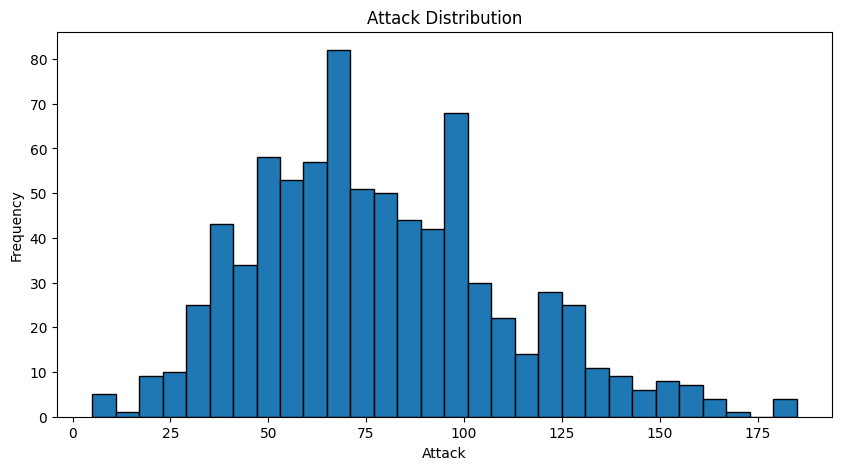

In [7]:
# Attack distribution
plt.figure(figsize=(10, 5))
plt.hist(df_pokemon['attack'].dropna(), bins=30, edgecolor='black')
plt.title('Attack Distribution')
plt.xlabel('Attack')
plt.ylabel('Frequency')
plt.show()

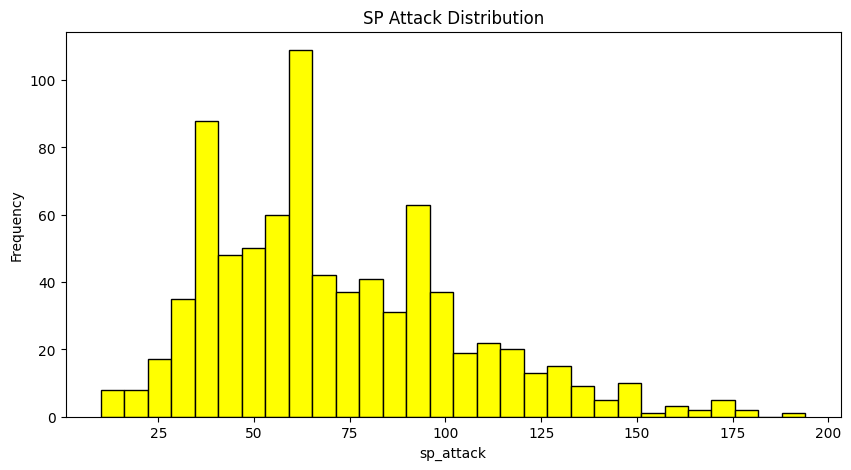

In [24]:
plt.figure(figsize=(10, 5))
plt.hist(df_pokemon['sp_attack'].dropna(), bins=30, edgecolor='black', color='yellow')
plt.title('SP Attack Distribution')
plt.xlabel('sp_attack')
plt.ylabel('Frequency')
plt.show()

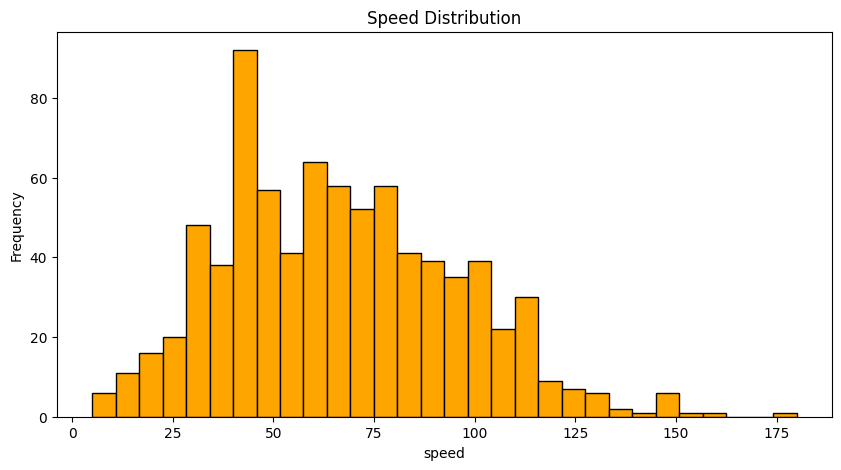

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(df_pokemon['speed'].dropna(), bins=30, edgecolor='black', color='orange')
plt.title('Speed Distribution')
plt.xlabel('speed')
plt.ylabel('Frequency')
plt.show()

# 4️⃣ Data Cleaning

In [8]:
# Define stat columns
stat_cols = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']

# Drop rows with missing stat values
df_clean = df_pokemon.dropna(subset=stat_cols).copy()
print(f"Shape after cleaning: {df_clean.shape}")

Shape after cleaning: (801, 41)


In [9]:
# Fill missing type2
df_clean['type2'] = df_clean['type2'].fillna('none')

# 5️⃣ Encode Categorical Variables

In [10]:
# Encode type columns
le = LabelEncoder()
df_clean['type1'] = le.fit_transform(df_clean['type1'])
df_clean['type2'] = le.fit_transform(df_clean['type2'])

# 6️⃣ Feature Engineering

In [11]:
# Total stats: overall power indicator
df_clean['total_stats'] = df_clean[stat_cols].sum(axis=1)

# Attack/defense ratio: offensive vs defensive Pokemon
df_clean['attack_defense_ratio'] = df_clean['attack'] / (df_clean['defense'] + 1)

df_clean[['total_stats', 'attack_defense_ratio']].head()

,total_stats,attack_defense_ratio
0,318,0.980000
1,405,0.968750
2,625,0.806452
3,309,1.181818
4,405,1.084746


# 7️⃣ Prepare Data

In [12]:
# Define features and target
feature_cols = stat_cols + ['total_stats', 'attack_defense_ratio', 'type1', 'type2']

X = df_clean[feature_cols]
y = df_clean['is_legendary']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Legendary in train: {y_train.sum()}, in test: {y_test.sum()}")

Train: (640, 10), Test: (161, 10)
Legendary in train: 56, in test: 14


In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8️⃣ Train Model

In [ ]:
# Train RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=15,
                               class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)
print("Model trained!")

Model trained!


**What does `class_weight='balanced'` do?**

When you have **class imbalance** (e.g., 700 Normal Pokemon, 50 Legendary), models tend to:
- Predict the majority class most of the time
- Ignore the minority class (it's "cheaper" to be wrong on rare cases)

`class_weight='balanced'` fixes this by:
1. Calculating weight for each class: `weight = n_samples / (n_classes * n_samples_in_class)`
2. Giving **higher penalty** to misclassifying the minority class
3. Example: If Normal:Legendary ratio is 10:1, Legendary errors cost 10x more


**Result:** Model pays equal attention to both classes, improving recall on minority class.

# 9️⃣ Evaluate Model

In [15]:
# Predictions and metrics
y_pred = model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Legendary']))

Accuracy: 0.9814

              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       147
   Legendary       1.00      0.79      0.88        14

    accuracy                           0.98       161
   macro avg       0.99      0.89      0.93       161
weighted avg       0.98      0.98      0.98       161



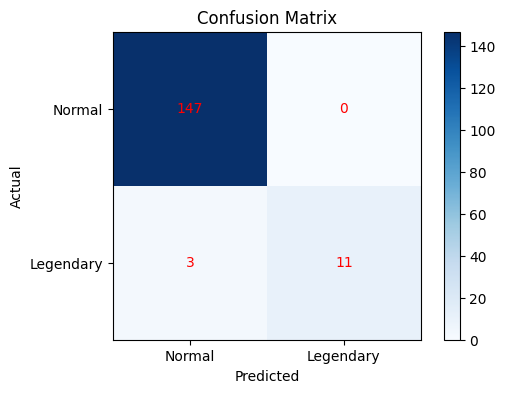

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Normal', 'Legendary'])
plt.yticks([0, 1], ['Normal', 'Legendary'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

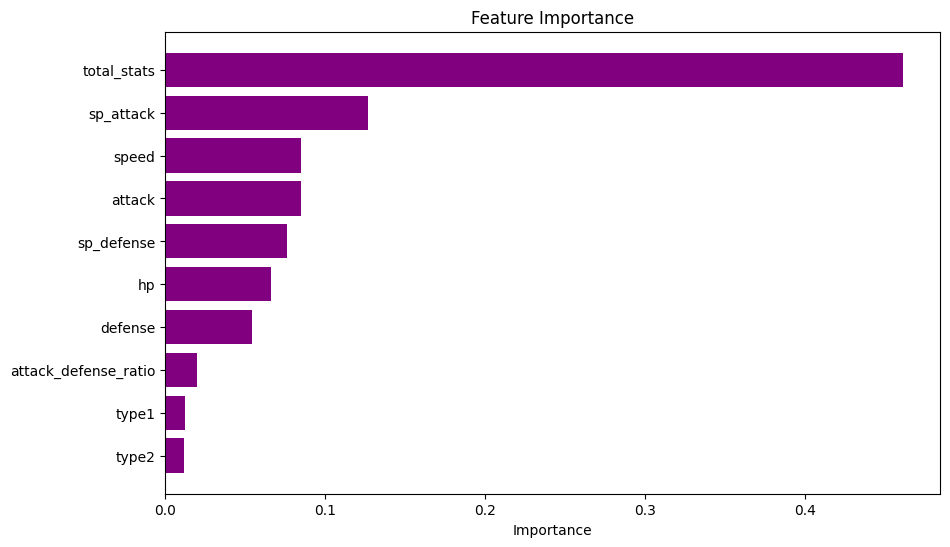

In [17]:
# Feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'], color='purple')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()